В рамках кейса необходимо решить следующие задачи:

1.	Обучить классификатор предсказывать сегмент по признакам на тренировочной выборке и
проверить работу классификатора на тестовой выборке, в которой отсутствуют метки сегментов;

2.	Используя таблицу признаков, кластеризовать пользователей и сравнить найденные кластеры с
сегментами, представленными в Dataset.

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')

In [18]:
def prepare_df(df, notrare, freq, replace_msk, train = 1):
    #колонки, которые не меняются
    if train ==1:
        df_train = df[['Segment','gamecategory','subgamecategory', 'city',]].copy()
    else:
        df_train = df[['gamecategory','subgamecategory', 'city',]].copy()
    #Написание устройства маленькими
    df_train['os'] = df.os.str.lower()
    print('os')
    #Только одно число в версии
    df_train['osv'] = df['osv'].str.split(".", n=1, expand=True)[0]
    df_train['osv'] = df_train['osv'].str.split("(", n=1, expand=True)[0]
    #для '10 / API-29'
    df_train['osv'] = df_train['osv'].str.split(" ", n=1, expand=True)[0]
    #удяляем меньше 1000
    df_train['osv'] = df_train['osv'].apply(lambda x: 0 if x not in notrare else x)
    df_train['osv'] = df_train['osv'].fillna(0).astype('int8')
    print('osv')
    #замена сдига времени на точное число
    df_train['shift'] = df['shift'].replace(replace_msk).fillna(0).astype("int8")
    df_train['local_created'] = df['created'] + pd.to_timedelta(df_train['shift'],'h')
    #Час и день недели создания файла
    df_train['hour_created'] = df_train['local_created'].dt.hour
    #понедельник 0
    df_train['day_created'] = df_train['local_created'].dt.dayofweek
    print('created')
    df_train['bundle'] = df['bundle'].apply(lambda x: 'rare' if x not in freq else x)
    
    return df_train[col_name]

## Простой анализ данных

In [2]:
col_name = ['Segment','gamecategory','subgamecategory','bundle','created','shift','city', 'os','osv']#'oblast',
#hackaton_train.csv.zip отдельно упакован трейн, без других файлов
X_train = pd.read_csv('hackaton_train.csv.zip', sep=',', parse_dates=['created'])[col_name] #, nrows=10000

In [3]:
X_train.head()

,Segment,gamecategory,subgamecategory,bundle,created,shift,city,os,osv
0,4,Games,Racing,com.MadOut.BIG,2021-07-05 18:07:40,MSK+6,Чита,android,10.0
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,2021-07-10 10:38:42,MSK+2,Оренбург,Android,10.0.0
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,2021-08-04 13:34:29,MSK,Санкт-Петербург,android,9.0
3,5,NaN,NaN,tcouchgind.scooterextreme.scooter,2021-08-06 07:35:27,MSK+2,Екатеринбург,android,9
4,4,NaN,NaN,com.FidgetTrading3D.game,2021-08-02 20:43:59,MSK,Звенигород,android,6.0.1


In [4]:
X_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44854516 entries, 0 to 44854515
Data columns (total 9 columns):
 #   Column           Non-Null Count     Dtype         
---  ------           --------------     -----         
 0   Segment          44854516 non-null  int64         
 1   gamecategory     27893185 non-null  object        
 2   subgamecategory  27886091 non-null  object        
 3   bundle           44837232 non-null  object        
 4   created          44854516 non-null  datetime64[ns]
 5   shift            41263366 non-null  object        
 6   city             40054524 non-null  object        
 7   os               44854283 non-null  object        
 8   osv              44854233 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 3.0+ GB


In [5]:
X_train.Segment.value_counts(normalize=True, dropna=False)

5    0.383183
3    0.316290
4    0.248405
2    0.031574
1    0.020547
Name: Segment, dtype: float64

In [6]:
X_train.gamecategory.value_counts(dropna=False)

Games                 24555534
NaN                   16961331
Applications           2742231
Lifestyle               267292
Shopping                184875
Entertainment            31465
Social Networking        28931
Education                27008
Book                     23483
Photo & Video            10235
Utilities                 7560
Music                     4571
IAB9-30                   3474
Health & Fitness          1423
Finance                   1322
Productivity              1314
Travel                     778
Sports                     614
Navigation                 332
Reference                  235
IAB9,IAB9-30,games         226
Graphics & Design           73
Business                    67
Medical                     66
Food & Drink                44
News                        23
Weather                      5
Stickers                     4
Name: gamecategory, dtype: int64

In [7]:
X_train.subgamecategory.nunique(dropna=False)

54

In [8]:
X_train.bundle.nunique(dropna=False)

85798

In [9]:
X_train.created.min(), X_train['created'][X_train.created >= pd.to_datetime('2021')].min(), X_train.created.max()

(Timestamp('1970-01-01 03:00:00'),
 Timestamp('2021-07-05 00:00:00'),
 Timestamp('2021-09-20 23:59:40'))

In [10]:
X_train['shift'].value_counts(dropna=False)

MSK      26308751
MSK+2     5987717
NaN       3591150
MSK+3     2875851
MSK+1     1895297
MSK+7     1445292
MSK+4     1098024
MSK+5      821276
MSK+6      535227
MSK-1      198047
MSK+9       76542
MSK+8       21342
Name: shift, dtype: int64

In [11]:
X_train['city'].nunique(dropna=False)

2499

In [12]:
X_train['os'].value_counts(dropna=False)

android    35245849
ios         5248627
Android     4253330
iOS          106477
NaN             233
Name: os, dtype: int64

In [13]:
X_train['osv'].nunique(dropna=False)

255

In [14]:
(X_train['osv'].value_counts()[(X_train['osv'].value_counts() > 10000) ==True].index).nunique()

74

In [15]:
freq = X_train['bundle'].value_counts()[(X_train['bundle'].value_counts() > 1000) ==True].index
len(freq)

3426

In [16]:
notrare = X_train['osv'].value_counts()[(X_train['osv'].value_counts() > 100) ==True].index
len(notrare)

175

### Подготовка датасета

Убираем строки со временем 1970 год, как ошибочные

In [19]:
X_train = X_train[X_train.created >= pd.to_datetime('2021')]

In [20]:
#Параметры для 44 млн freq > 1000 (3426 уникальных) notrare > 100 (175 уникальных)
notrare = X_train['osv'].value_counts()[(X_train['osv'].value_counts() > 100) ==True].index
freq = X_train['bundle'].value_counts()[(X_train['bundle'].value_counts() > 1000) ==True].index
replace_msk = {'MSK': 0, 'MSK+1': 1, 'MSK+2': 2, 'MSK+3': 3, 'MSK+4': 4, 'MSK+5': 5, 'MSK+6': 6, 
               'MSK+7': 7, 'MSK+8': 8, 'MSK+9': 9, 'MSK-1': -1}
col_name = ['Segment', 'gamecategory', 'subgamecategory', 'bundle', 'city', 'os', 'osv', 'hour_created', 
            'day_created']    

In [21]:
df_train = prepare_df(X_train, notrare, freq, replace_msk, train = 1)
df_train.head()

os
osv
created


,Segment,gamecategory,subgamecategory,bundle,city,os,osv,hour_created,day_created
0,4,Games,Racing,com.MadOut.BIG,Чита,android,10,0,1
1,4,NaN,NaN,com.easybrain.solitaire.klondike.free,Оренбург,android,10,12,5
2,5,Games,Arcade,com.orbitalknight.ridiculousfreekick,Санкт-Петербург,android,9,13,2
3,5,NaN,NaN,rare,Екатеринбург,android,9,9,4
4,4,NaN,NaN,com.FidgetTrading3D.game,Звенигород,android,0,20,0


In [22]:
col_name = ['Segment', 'gamecategory', 'subgamecategory', 'bundle', 'city', 'os', 'osv', 'hour_created', 
            'day_created']
df_train[col_name].to_csv("train.csv.gz", header = True, index= False, compression='gzip')

In [23]:
np.savetxt("notrare.txt", notrare, newline="\n", fmt='%s')
np.savetxt("freq.txt", freq, newline="\n", fmt='%s')

Создадим отложенную выборку для расчета метрики

In [24]:
#7 и 8 месяцы в тренировочный, а 9 в отложенный
#df_train = X_train[X_train.local_created < pd.to_datetime('2021-09')]
#df_hold = X_train[X_train.local_created >= pd.to_datetime('2021-09')]

In [25]:
#col_name = ['Segment', 'gamecategory', 'subgamecategory', 'bundle', 'city', 'os', 'osv', 'hour_created', 
#            'day_created']

In [24]:
df_train, df_hold = train_test_split(df_train, test_size=0.4, random_state=42, stratify=df_train.Segment)

In [25]:
df_train[col_name].to_csv("df_train.csv.gz", header = True, index= False, compression='gzip')

In [26]:
df_hold[col_name].to_csv("df_hold.csv.gz", header = True, index= False, compression='gzip')

### Обработка тестового датасета

In [ ]:
col_name = ['gamecategory','subgamecategory','bundle','created','shift','city', 'os','osv']#'oblast',
#hackaton_train.csv.zip отдельно упакован трейн, без других файлов
X_test = pd.read_csv('hackathon_test.zip', sep=',', parse_dates=['created'])[col_name]

In [15]:
notrare = list(np.loadtxt("notrare.txt", delimiter="\n", dtype=str))
freq = list(np.loadtxt("freq.txt", delimiter="\n", dtype=str))
replace_msk = {'MSK': 0, 'MSK+1': 1, 'MSK+2': 2, 'MSK+3': 3, 'MSK+4': 4, 'MSK+5': 5, 'MSK+6': 6, 
               'MSK+7': 7, 'MSK+8': 8, 'MSK+9': 9, 'MSK-1': -1}
col_name = ['gamecategory', 'subgamecategory', 'bundle', 'city', 'os', 'osv', 'hour_created', 
            'day_created'] 

In [19]:
df_test = prepare_df(X_test, notrare, freq, replace_msk, train = 0)
df_test.head()

os
osv
created


,gamecategory,subgamecategory,bundle,city,os,osv,hour_created,day_created
0,Applications,Shopping,com.allgoritm.youla,Екатеринбург,android,10,19,6
1,NaN,NaN,rare,Новый Уренгой,android,10,19,1
2,NaN,NaN,1387897651,Москва,ios,0,15,4
3,NaN,NaN,com.cooking.family.diary.fever.food.city.craze...,Краснодар,android,9,23,0
4,Applications,Health & Fitness,com.pedometer.stepcounter.tracker,Набережные Челны,android,10,15,3


In [20]:
df_test[col_name].to_csv("df_test.csv.gz", header = True, index= False, compression='gzip')

##  Проверка точности модели на отложенной выборке
Тут перезапускаю ноутбук, т.к. вся память забита

In [2]:
df_train = pd.read_csv('df_train.csv.gz', sep=',') #, nrows=10000000

In [3]:
df_hold = pd.read_csv('df_hold.csv.gz', sep=',')

In [4]:
df_train['gamecategory'] = df_train['gamecategory'].fillna(" ")
df_train['subgamecategory'] = df_train['gamecategory'].fillna(" ")
df_train['bundle'] = df_train['bundle'].fillna(" ")
df_train['city'] = df_train['city'].fillna(" ")

In [5]:
df_hold['gamecategory'] = df_hold['gamecategory'].fillna(" ")
df_hold['subgamecategory'] = df_hold['gamecategory'].fillna(" ")
df_hold['bundle'] = df_hold['bundle'].fillna(" ")
df_hold['city'] = df_hold['city'].fillna(" ")

In [6]:
df_train.head()

,Segment,gamecategory,subgamecategory,bundle,city,os,osv,hour_created,day_created
0,4,Games,Games,com.miniclip.bowmasters,Саратов,android,11,16,1
1,3,Games,Games,com.playgendary.creamaster,Ижевск,android,0,23,1
2,4,,,com.iposedon.bricksbreakerballs,Москва,android,10,7,5
3,5,Games,Games,com.bigfishgames.mergetalesgoog,Владивосток,android,11,17,3
4,4,,,com.armnomads.hamstermazer,Москва,android,0,20,0


In [5]:
#df = df_train.sample(frac=0.1, replace=False, random_state=42)

In [7]:
features = ['gamecategory', 'subgamecategory', 'bundle', 'city', 'os', 'osv', 'hour_created', 'day_created']
cat_feat = ['gamecategory', 'subgamecategory', 'bundle', 'city', 'os', ]

X_train_part, X_valid, y_train_part, y_valid = train_test_split(df_train[features], df_train.Segment, 
                                                                test_size=0.2, 
                                                                random_state=42, stratify=df_train.Segment)

In [8]:
cat_clf = CatBoostClassifier(loss_function = 'MultiClass', eval_metric= "AUC", random_state=42, task_type='GPU', 
                          learning_rate=0.1, leaf_estimation_iterations=1, max_depth = 4, n_estimators = 2000)

In [9]:
cat_clf.fit(X_train_part, y_train_part, eval_set=(X_valid, y_valid), verbose=10, cat_features = cat_feat,
                 early_stopping_rounds = 50, use_best_model=True)

AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5992642	best: 0.5992642 (0)	total: 1.38s	remaining: 46m
10:	test: 0.7386585	best: 0.7386585 (10)	total: 15.7s	remaining: 47m 11s
20:	test: 0.7634535	best: 0.7634535 (20)	total: 33.3s	remaining: 52m 21s
30:	test: 0.7810293	best: 0.7810293 (30)	total: 51.7s	remaining: 54m 41s
40:	test: 0.7910190	best: 0.7910190 (40)	total: 1m 10s	remaining: 55m 52s
50:	test: 0.7965124	best: 0.7965124 (50)	total: 1m 33s	remaining: 59m 52s
60:	test: 0.8008292	best: 0.8008292 (60)	total: 1m 58s	remaining: 1h 2m 42s
70:	test: 0.8056439	best: 0.8056439 (70)	total: 2m 18s	remaining: 1h 2m 37s
80:	test: 0.8081608	best: 0.8081608 (80)	total: 2m 37s	remaining: 1h 2m 16s
90:	test: 0.8120458	best: 0.8120458 (90)	total: 2m 58s	remaining: 1h 2m 34s
100:	test: 0.8150378	best: 0.8150378 (100)	total: 3m 19s	remaining: 1h 2m 31s
110:	test: 0.8167769	best: 0.8167769 (110)	total: 3m 39s	remaining: 1h 2m 10s
120:	test: 0.8195094	best: 0.8195094 (120)	total: 3m 58s	remaining: 1h 1m 41s
130:	test: 0.8212027	best: 0

1080:	test: 0.8466024	best: 0.8466024 (1080)	total: 34m 18s	remaining: 29m 9s
1090:	test: 0.8466513	best: 0.8466513 (1090)	total: 34m 36s	remaining: 28m 50s
1100:	test: 0.8467286	best: 0.8467286 (1100)	total: 34m 55s	remaining: 28m 31s
1110:	test: 0.8467803	best: 0.8467803 (1110)	total: 35m 14s	remaining: 28m 12s
1120:	test: 0.8468298	best: 0.8468298 (1120)	total: 35m 33s	remaining: 27m 52s
1130:	test: 0.8468761	best: 0.8468761 (1130)	total: 35m 52s	remaining: 27m 33s
1140:	test: 0.8469321	best: 0.8469321 (1140)	total: 36m 11s	remaining: 27m 14s
1150:	test: 0.8469722	best: 0.8469722 (1150)	total: 36m 30s	remaining: 26m 56s
1160:	test: 0.8469995	best: 0.8469995 (1160)	total: 36m 49s	remaining: 26m 36s
1170:	test: 0.8470889	best: 0.8470889 (1170)	total: 37m 8s	remaining: 26m 17s
1180:	test: 0.8471548	best: 0.8471548 (1180)	total: 37m 27s	remaining: 25m 58s
1190:	test: 0.8472092	best: 0.8472092 (1190)	total: 37m 46s	remaining: 25m 39s
1200:	test: 0.8472942	best: 0.8472942 (1200)	total: 38

In [10]:
cat_predict = cat_clf.predict_proba(df_hold[features])

In [11]:
roc_auc_score(df_hold.Segment, cat_predict, multi_class='ovr')

0.806518411939062

Text(0.5, 0, 'Важность')

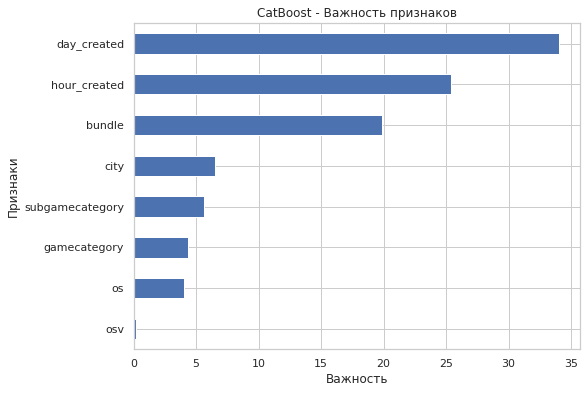

In [14]:
fea_imp = pd.DataFrame({'imp': cat_clf.feature_importances_, 'col': X_train_part.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(8, 6), legend=None)
plt.title('CatBoost - Важность признаков')
plt.ylabel('Признаки')
plt.xlabel('Важность')

In [15]:
#Сохранение модели CatBoostClassifier
cat_clf.save_model('cat_clf.cbm')
#Загрузка модели
#cat_clf = CatBoostClassifier() 
#cat_clf.load_model('cat_clf.cbm')

## Предсказание на тестовом датасете

In [16]:
df_test = pd.read_csv('df_test.csv.gz', sep=',')

In [17]:
df_test['gamecategory'] = df_test['gamecategory'].fillna(" ")
df_test['subgamecategory'] = df_test['gamecategory'].fillna(" ")
df_test['bundle'] = df_test['bundle'].fillna(" ")
df_test['city'] = df_test['city'].fillna(" ")
df_test['os'] = df_test['os'].fillna(" ")

In [18]:
# Простое предсказание
y_pred = cat_clf.predict_proba(df_test[features])

Предсказание по фолдам

In [20]:
clf = CatBoostClassifier(loss_function = 'MultiClass', eval_metric= "AUC", random_state=42, task_type='GPU', 
                          learning_rate=0.1, leaf_estimation_iterations=1, max_depth = 4, n_estimators = 100)

features = ['gamecategory', 'subgamecategory', 'bundle', 'city', 'os', 'osv', 'hour_created', 'day_created']
cat_feat = ['gamecategory', 'subgamecategory', 'bundle', 'city', 'os',]

X_train = df_train[features]
y_train = df_train.Segment
X_test = df_test[features]

num_folds = 5
folds = KFold(n_splits= num_folds, shuffle=True, random_state=42)
y_pred = np.zeros((X_test.shape[0], 5))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_ + 1))
    X_trn = X_train.iloc[trn_idx]
    y_trn = y_train.iloc[trn_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    clf.fit(X_trn, y_trn, eval_set=(X_val, y_val), verbose=10, cat_features = cat_feat,
                 early_stopping_rounds = 50, use_best_model=True)
    
    y_pred += clf.predict_proba(X_test) / folds.n_splits

fold n°1


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5976287	best: 0.5976287 (0)	total: 416ms	remaining: 41.2s
10:	test: 0.7367551	best: 0.7367551 (10)	total: 5.54s	remaining: 44.8s
20:	test: 0.7634506	best: 0.7634506 (20)	total: 11.9s	remaining: 44.9s
30:	test: 0.7803990	best: 0.7803990 (30)	total: 18.6s	remaining: 41.4s
40:	test: 0.7915571	best: 0.7915571 (40)	total: 25.4s	remaining: 36.5s
50:	test: 0.7996821	best: 0.7996821 (50)	total: 32.1s	remaining: 30.9s
60:	test: 0.8042722	best: 0.8042722 (60)	total: 38.9s	remaining: 24.9s
70:	test: 0.8088857	best: 0.8088857 (70)	total: 45.8s	remaining: 18.7s
80:	test: 0.8123449	best: 0.8123449 (80)	total: 52.7s	remaining: 12.4s
90:	test: 0.8138525	best: 0.8138525 (90)	total: 59.5s	remaining: 5.89s
99:	test: 0.8155929	best: 0.8155929 (99)	total: 1m 5s	remaining: 0us
bestTest = 0.8155929066
bestIteration = 99
fold n°2


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5970720	best: 0.5970720 (0)	total: 423ms	remaining: 41.8s
10:	test: 0.7357311	best: 0.7357311 (10)	total: 5.74s	remaining: 46.4s
20:	test: 0.7623828	best: 0.7623828 (20)	total: 12.6s	remaining: 47.4s
30:	test: 0.7797348	best: 0.7797348 (30)	total: 20.4s	remaining: 45.4s
40:	test: 0.7890770	best: 0.7890770 (40)	total: 27.9s	remaining: 40.2s
50:	test: 0.7955616	best: 0.7955616 (50)	total: 35.1s	remaining: 33.7s
60:	test: 0.8001444	best: 0.8001444 (60)	total: 42.4s	remaining: 27.1s
70:	test: 0.8057147	best: 0.8057147 (70)	total: 49.7s	remaining: 20.3s
80:	test: 0.8084450	best: 0.8084450 (80)	total: 56.9s	remaining: 13.3s
90:	test: 0.8119124	best: 0.8119124 (90)	total: 1m 3s	remaining: 6.3s
99:	test: 0.8144878	best: 0.8144878 (99)	total: 1m 9s	remaining: 0us
bestTest = 0.8144878415
bestIteration = 99
fold n°3


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5980240	best: 0.5980240 (0)	total: 417ms	remaining: 41.3s
10:	test: 0.7393918	best: 0.7393918 (10)	total: 5.46s	remaining: 44.2s
20:	test: 0.7636355	best: 0.7636355 (20)	total: 11.9s	remaining: 44.8s
30:	test: 0.7810153	best: 0.7810153 (30)	total: 18.6s	remaining: 41.5s
40:	test: 0.7913401	best: 0.7913401 (40)	total: 25.5s	remaining: 36.7s
50:	test: 0.7984423	best: 0.7984423 (50)	total: 32.4s	remaining: 31.1s
60:	test: 0.8039716	best: 0.8039716 (60)	total: 39.5s	remaining: 25.2s
70:	test: 0.8076310	best: 0.8076310 (70)	total: 46.5s	remaining: 19s
80:	test: 0.8120204	best: 0.8120204 (80)	total: 53.6s	remaining: 12.6s
90:	test: 0.8152193	best: 0.8152193 (90)	total: 1m 1s	remaining: 6.04s
99:	test: 0.8168796	best: 0.8168796 (99)	total: 1m 7s	remaining: 0us
bestTest = 0.8168795988
bestIteration = 99
fold n°4


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5976698	best: 0.5976698 (0)	total: 433ms	remaining: 42.9s
10:	test: 0.7368393	best: 0.7368393 (10)	total: 5.7s	remaining: 46.1s
20:	test: 0.7664828	best: 0.7664828 (20)	total: 12.3s	remaining: 46.3s
30:	test: 0.7803888	best: 0.7803888 (30)	total: 19s	remaining: 42.2s
40:	test: 0.7908165	best: 0.7908165 (40)	total: 25.7s	remaining: 37s
50:	test: 0.7984854	best: 0.7984854 (50)	total: 32.8s	remaining: 31.5s
60:	test: 0.8032665	best: 0.8032665 (60)	total: 39.5s	remaining: 25.3s
70:	test: 0.8079585	best: 0.8079585 (70)	total: 46.5s	remaining: 19s
80:	test: 0.8106401	best: 0.8106401 (80)	total: 53.5s	remaining: 12.6s
90:	test: 0.8123841	best: 0.8123841 (90)	total: 1m	remaining: 6s
99:	test: 0.8145521	best: 0.8145521 (99)	total: 1m 6s	remaining: 0us
bestTest = 0.8145521047
bestIteration = 99
fold n°5


AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5972014	best: 0.5972014 (0)	total: 407ms	remaining: 40.3s
10:	test: 0.7391441	best: 0.7391441 (10)	total: 5.63s	remaining: 45.6s
20:	test: 0.7638047	best: 0.7638047 (20)	total: 12.1s	remaining: 45.7s
30:	test: 0.7811817	best: 0.7811817 (30)	total: 19s	remaining: 42.3s
40:	test: 0.7903357	best: 0.7903357 (40)	total: 25.7s	remaining: 37s
50:	test: 0.7974763	best: 0.7974763 (50)	total: 32.6s	remaining: 31.3s
60:	test: 0.8014602	best: 0.8014602 (60)	total: 39.5s	remaining: 25.3s
70:	test: 0.8069625	best: 0.8069625 (70)	total: 46.6s	remaining: 19s
80:	test: 0.8104964	best: 0.8104964 (80)	total: 53.6s	remaining: 12.6s
90:	test: 0.8128030	best: 0.8128030 (90)	total: 1m	remaining: 5.98s
99:	test: 0.8143880	best: 0.8143880 (99)	total: 1m 6s	remaining: 0us
bestTest = 0.8143880432
bestIteration = 99


In [21]:
df_predictions = pd.DataFrame(y_pred, index=df_test.index, 
                              columns=['{}'.format(class_id) for class_id in clf.classes_],)
df_predictions = df_predictions.astype('float16')
df_predictions.head()

,1,2,3,4,5
0,0.000503,0.015686,0.610352,0.070801,0.302734
1,0.047058,0.000031,0.183838,0.704102,0.064941
2,0.032349,0.030014,0.514648,0.090881,0.332275
3,0.029678,0.000011,0.621094,0.324951,0.024017
4,0.013596,0.012451,0.408447,0.454346,0.111084


In [22]:
#в тесте нет индекса
compression_opts = dict(method='zip', archive_name='results.csv') 
df_predictions.to_csv("results.zip", header = True, index= False, compression=compression_opts)